In [2]:
'''This is the version that drops the rows'''

import dask.dataframe as dd

#Load the entire dataset with Dask
train_data = dd.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet')

#Filter out the first 85 days
train_data = train_data[train_data['date_id'] >= 85]
#Drop fully empty (all-NaN) partitions to save memory
def drop_empty_partitions(df):
    return df.dropna(how='all')

train_data = train_data.map_partitions(drop_empty_partitions)

#Define a function to interpolate within each partition(moved outside the function for later data observation)
numerical_columns = train_data.select_dtypes(include=['number']).columns

# Updated interpolate function
def interpolate_partition(df):
    # Perform interpolation
    df[numerical_columns] = df[numerical_columns].interpolate(method='linear', limit_direction='both')
    return df

# Apply the interpolation function to each partition
train_data = train_data.map_partitions(interpolate_partition)
train_data = train_data.dropna(how='any')

#Verify if there are any remaining NaNs
remaining_na = train_data.isna().sum().sum().compute()
print("Remaining NaNs after interpolation:", remaining_na)


Remaining NaNs after interpolation: 0


In [ ]:
# Compute summary statistics
summary = train_data[numerical_columns].describe(percentiles = [0.25, 0.5, 0.75]).compute()
print(summary)

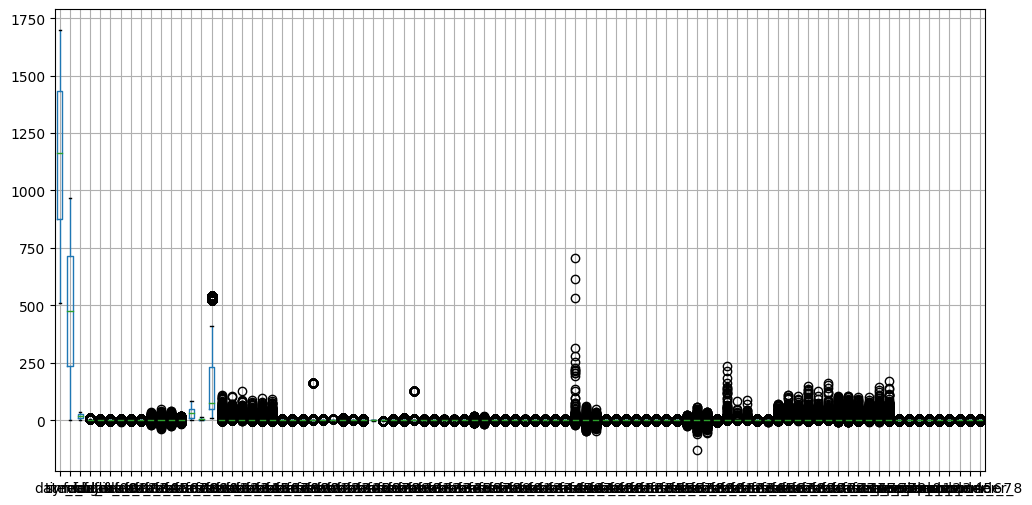

In [3]:
#visualize the data

import matplotlib.pyplot as plt

# Sample some data to visualize
sampled_data = train_data[numerical_columns].sample(frac=0.1).compute()

# Plot boxplots
sampled_data.boxplot(figsize=(12, 6))
plt.show()

In [ ]:
# Compute summary statistics
summary = train_data[numerical_columns].describe().compute()

# Plot summary statistics
summary.T[['min', '25%', '50%', '75%', 'max']].plot(kind='bar', figsize=(12, 6))
plt.title("Summary Statistics")
plt.show()


In [ ]:
# Compute IQR thresholds
q1 = train_data[numerical_columns].quantile(0.25).compute()
q3 = train_data[numerical_columns].quantile(0.75).compute()
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print("Lower bounds:\n", lower_bound)
print("Upper bounds:\n", upper_bound)

In [ ]:
# Count outliers - Doesnt work!!!
import numpy as np

lower_bound_array = np.array([lower_bound[col] for col in numerical_columns])
upper_bound_array = np.array([upper_bound[col] for col in numerical_columns])

outliers = (train_data[numerical_columns]< lower_bound_array) | (train_data[numberica_columns] > upper_bound_array)
outlier_counts = outliers.sum().computer()
print("Outlier counts:\n", outlier_counts)


In [ ]:
'''After applying the interpolation, I am still left with many NaN values. To tackle this,
I have two main courses of action, I can either completely drop these rows, or I can use median 
values as default placeholders. Although I believe that simply dropping these rows would be
the best strategy(given that they represent a very small portion of the data) There is no way 
to be sure.

because of this, i have decided to maintain two version of the data, one based on dropping nan 
rows, and the other based on median filling. I can cross validate these two later to deterine
                which is the best option to proceed with'''

In [ ]:
'''The code beyond this point is soley for the purpose of documenting my data exploration/experimentatin. 
although it is mostly the same logic as above, it cannot be guarenteed to run, nor can 
it be guarenteed to provide clean data.'''

In [ ]:
'''This is the version that fills remaining NaNs with medians'''

import dask.dataframe as dd

# Load the entire dataset with Dask
train_data = dd.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet')

# Filter out the first 85 days
train_data = train_data[train_data['date_id'] >= 85]

# Drop fully empty (all-NaN) partitions to save memory
def drop_empty_partitions(df):
    return df.dropna(how='all')

train_data = train_data.map_partitions(drop_empty_partitions)

# Define a function to interpolate within each partition
def interpolate_partition(df):
    # Interpolate numerical columns only
    numerical_columns = df.select_dtypes(include=['number']).columns
    # Perform interpolation in multiple steps
    df[numerical_columns] = df[numerical_columns].interpolate(method='linear', limit_direction='both')
    return df

# Apply the interpolation function to each partition
train_data = train_data.map_partitions(interpolate_partition)

# Compute medians for numerical columns
# Sample a fraction of data to compute medians, adjusting `frac` as per memory constraints
sample_data = train_data.sample(frac=0.1).compute()  # Adjust `frac` as necessary
# Compute medians for numeric columns only
numeric_columns = sample_data.select_dtypes(include=['number'])
medians = numeric_columns.median()

# Fill remaining NaNs in the dataset with median values for numeric columns
train_data = train_data.map_partitions(
    lambda df: df.fillna(medians.to_dict())
)

# Optional: Verify if there are any remaining NaNs
remaining_na = train_data.isna().sum().sum().compute()
print("Remaining NaNs after interpolation and filling with medians:", remaining_na)


In [ ]:
''' this is no longer needed given that we are now using interprolation instead.

#Apply fillna with a limit to handle short gaps but retain larger missing sections
train_data = train_data.bfill(limit=5000).ffill(limit=5000)

#Sample 10% of the data to compute medians
sample_data = train_data.sample(frac=0.1).compute()

#Select only numeric columns
numeric_columns = sample_data.select_dtypes(include=['number'])
medians = numeric_columns.median()

# Step 4: Fill remaining NaNs using column-specific medians
train_data = train_data.fillna(medians.to_dict())

# Optional: Check for remaining NaNs if needed
remaining_na = train_data.isna().sum().sum().compute()
print("Remaining NaNs after fill:", remaining_na)



In [ ]:
import dask.dataframe as dd

# Load the dataset in Dask (memory-efficient)
data_path = '/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet'
train_data = dd.read_parquet(data_path)

# Take a 10% random sample of the data for initial inspection
sample_data = train_data.sample(frac=0.1, random_state=42).compute()  # Converts to pandas


In [ ]:

# Check the first few rows of the sample
print(sample_data.head())

# Check the data types of each column
#print(sample_data.dtypes)

# Get general information about the data, including non-null counts
#print(sample_data.info())


In [ ]:
# Get the total number of rows (compute once for efficiency)
total_rows = len(train_data)

# Count missing values in each column
missing_values = train_data.isna().sum().compute()  # .compute() to get concrete values in pandas

# Identify columns where the count of NaNs is equal to the total number of rows
all_nan_columns = missing_values[missing_values == total_rows].index
print("Columns with all NaN values:", all_nan_columns.tolist())

In [ ]:
#test what percent of each column is filled with NaN values
#will hopefully help determine which ones are causing the fill NaN error

import pandas as pd

# Calculate NaN percentages
nan_percentage = train_data.isna().mean().compute() * 100  # Compute to get concrete values in pandas

# Sort columns by NaN percentage in descending order (highest NaN percentage at the top)
nan_percentage_sorted = nan_percentage.sort_values(ascending=False)

# Display all columns with NaN percentages
pd.set_option('display.max_rows', None)  # Show all rows without truncation
print("NaN percentage per column (sorted):\n", nan_percentage_sorted)
pd.reset_option('display.max_rows')  # Reset display option back to default

'''
NaN percentage per column (sorted):
 feature_26      17.900406
feature_21      17.900406
feature_27      17.900406
feature_31      17.900406
feature_42       9.125593
feature_39       9.125593
feature_50       9.026816
feature_53       9.026816
feature_00       6.752030
feature_01       6.752030
feature_02       6.752030
feature_03       6.752030
feature_04       6.752030
feature_15       2.566024
feature_41       2.319274
feature_44       2.319274
feature_52       2.217180
feature_55       2.217180
feature_74       1.026493
feature_73       1.026493
'''


In [ ]:

# Count missing values in each column
missing_values = sample_data.isna().sum()
print("Missing values per column:\n", missing_values)

# Show only columns with missing values for better clarity
missing_columns = missing_values[missing_values > 0]
print("Columns with missing values:\n", missing_columns)


In [ ]:
# Filter to exclude the first 85 days
sample_data = sample_data[sample_data['date_id'] >= 85]
print("Data after filtering the first 85 days:", sample_data.shape)


In [ ]:
# Apply backward-fill, then forward-fill
sample_data = sample_data.bfill().ffill()

# Verify that there are no remaining missing values
print("Remaining missing values:", sample_data.isna().sum().sum())  # Should be 0 if all NaNs are filled
